## 3.2 Comparação com baselines ingênuos

Objetivo: Comparar resultados e métricas obtidas com modelos ingênuos a fim de entender quão bom é nosso modelo

### Importação das bibliotecas

In [1]:
import pandas as pd
import joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

### Carregando os dados

In [2]:
# Carregando os dados já divididos e processados
X_train = pd.read_csv('../data/processed/X_train.csv', sep=';')
X_test = pd.read_csv('../data/processed/X_test.csv', sep=';')
y_train = pd.read_csv('../data/processed/y_train.csv', sep=';').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv', sep=';').squeeze()

print(f"Treino: {X_train.shape[0]} amostras × {X_train.shape[1]} features")
print(f"Teste: {X_test.shape[0]} amostras × {X_test.shape[1]} features")

Treino: 662 amostras × 13 features
Teste: 285 amostras × 13 features


### Carregando o melhor modelo

In [3]:
model_path = Path('../models/best_model.pkl')
best_model = joblib.load(model_path)

### Definindo baselines e os treinando

Para os baselines escolhemos três modelos ingênuos:

- **Aleatório**: realiza previsões escolhendo aleatoriamente entre as duas classes, com probabilidades iguais.
- **Classe mais frequente**: sempre prevê a classe com maior predominância no conjunto de dados.
- **Estratificado**: realiza previsões aleatórias, mas respeitando a distribuição das classes observada no conjunto de treinamento.

In [4]:
baselines = {
    'Aleatório': DummyClassifier(strategy='uniform'),
    'Classe mais Frequente': DummyClassifier(strategy='most_frequent'),
    'Estratificado': DummyClassifier(strategy='stratified')
}

for name, model in baselines.items():
    model.fit(X_train, y_train)

print("Baselines criados e treinados.")

Baselines criados e treinados.


### Avaliando e fazendo comparativo

In [5]:
results_comparison = {}

y_pred_best = best_model.predict(X_test)
results_comparison['Melhor Modelo'] = {
    'Acurácia': accuracy_score(y_test, y_pred_best),
    'F1-Score': f1_score(y_test, y_pred_best, average='weighted'),
    'Precisão': precision_score(y_test, y_pred_best, average='weighted'),
    'Recall': recall_score(y_test, y_pred_best, average='weighted')
}

for name, model in baselines.items():
    y_pred = model.predict(X_test)
    results_comparison[name] = {
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Precisão': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }

df_results = pd.DataFrame(results_comparison).T
print("\n" + "="*70)
print("COMPARAÇÃO: MELHOR MODELO vs BASELINES")
print("="*70)
print(df_results.round(4))


COMPARAÇÃO: MELHOR MODELO vs BASELINES
                       Acurácia  F1-Score  Precisão  Recall
Melhor Modelo            0.9544    0.9544    0.9547  0.9544
Aleatório                0.4842    0.4856    0.4879  0.4842
Classe mais Frequente    0.5579    0.3996    0.3112  0.5579
Estratificado            0.5088    0.5083    0.5080  0.5088


c:\Users\paulo\miniconda3\envs\ligia\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Curvas ROC/PR (Melhor modelo vs baselines)
Aqui comparamos a capacidade discriminatória do melhor modelo com os baselines usando **ROC/AUC** e **PR/AUPRC**.

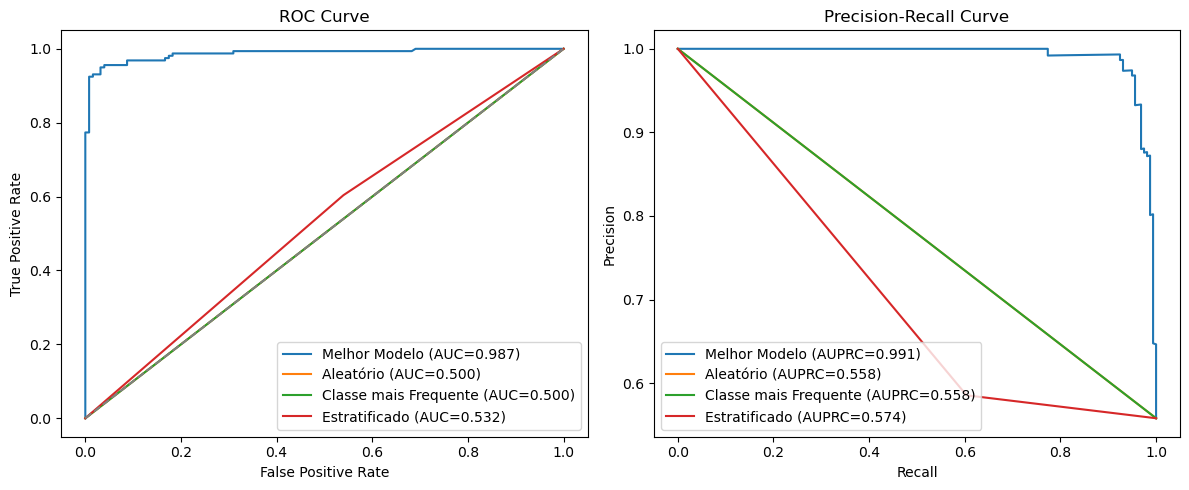


ROC AUC / PR AUPRC
                       ROC AUC  PR AUPRC
Melhor Modelo           0.9872    0.9915
Aleatório               0.5000    0.5579
Classe mais Frequente   0.5000    0.5579
Estratificado           0.5320    0.5745


In [6]:
# Função para obter score contínuo (probabilidade ou decision_function)
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    raise ValueError("Modelo não possui predict_proba nem decision_function.")

models_for_curves = {'Melhor Modelo': best_model}
models_for_curves.update(baselines)

roc_data = {}
pr_data = {}

for name, model in models_for_curves.items():
    y_scores = get_scores(model, X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    roc_data[name] = (fpr, tpr, roc_auc)
    pr_data[name] = (recall, precision, avg_precision)

# Plot ROC e PR
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
for name, (recall, precision, avg_precision) in pr_data.items():
    plt.plot(recall, precision, label=f'{name} (AUPRC={avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Tabela resumo de AUC/AUPRC
df_auc = pd.DataFrame({
    name: {'ROC AUC': roc_data[name][2], 'PR AUPRC': pr_data[name][2]}
    for name in roc_data
}).T
print("\n" + "="*70)
print("ROC AUC / PR AUPRC")
print("="*70)
print(df_auc.round(4))

### Por que PR/AUPRC é mais informativa que ROC/AUC em dados desbalanceados
Em dados desbalanceados, a **ROC/AUC** pode parecer boa porque a taxa de falsos positivos é diluída pela grande quantidade de negativos. Já a **PR/AUPRC** foca diretamente na qualidade das previsões positivas (precision) versus a capacidade de encontrar positivos (recall), sendo mais sensível e informativa para o caso clínico.

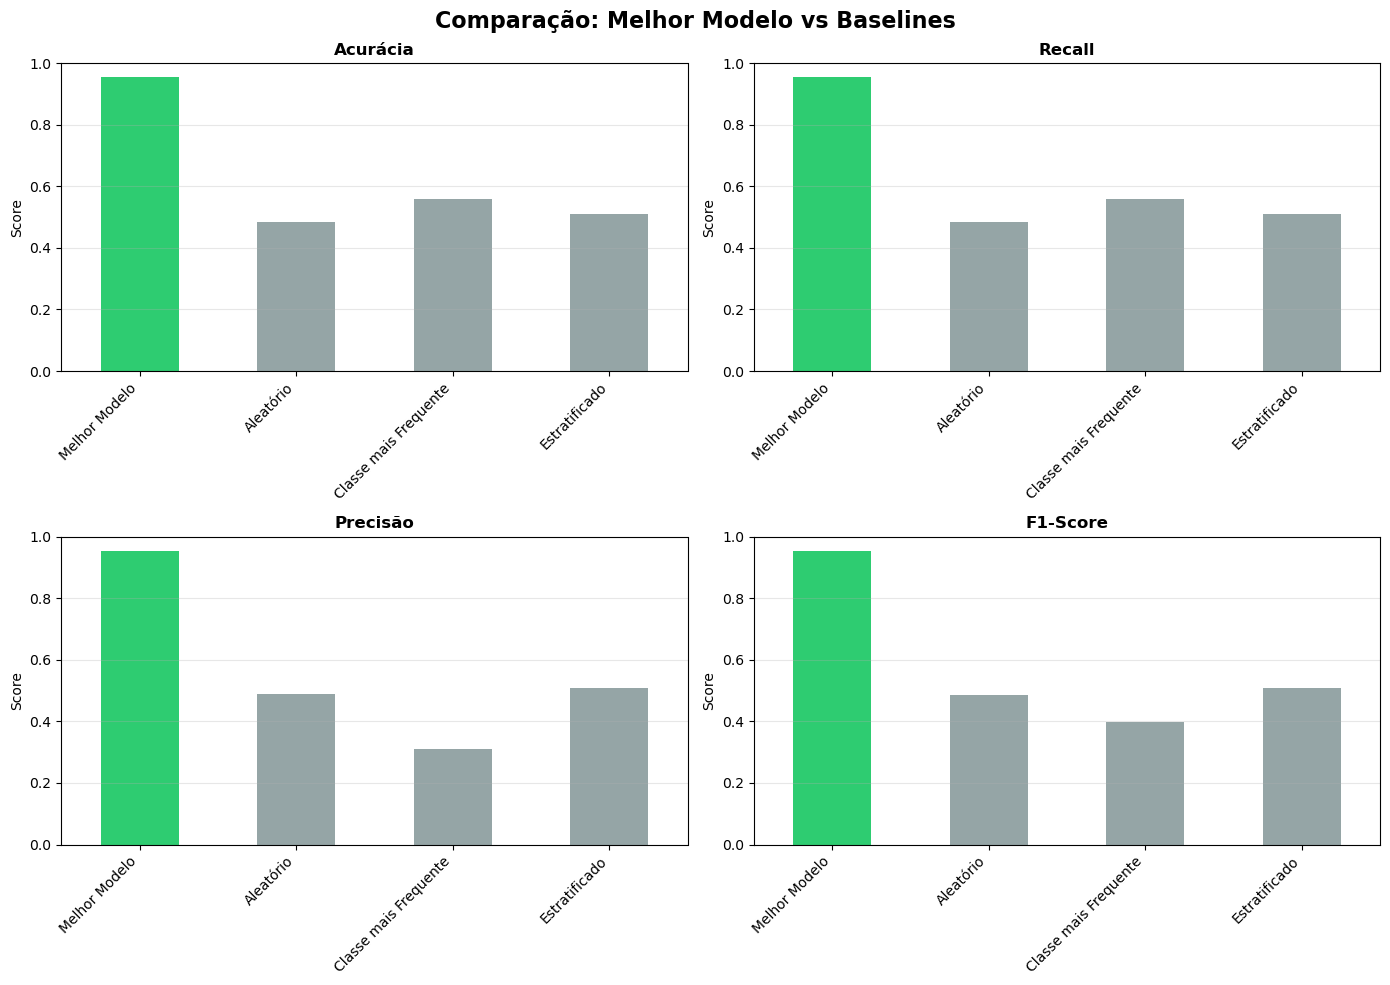

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparação: Melhor Modelo vs Baselines', fontsize=16, fontweight='bold')

metrics = ['Acurácia', 'Recall', 'Precisão', 'F1-Score']
colors = ['#2ecc71' if i == 0 else '#95a5a6' for i in range(len(df_results))]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    df_results[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

O gráfico evidencia que o melhor modelo supera de forma consistente todas as baselines ingênuas em todas as métricas avaliadas. Esse ganho é particularmente relevante na métrica de recall, definida como a mais importante para o problema em questão, indicando que o modelo proposto é significativamente mais eficaz em identificar corretamente os exemplos da classe positiva.

Esse resultado sugere que o modelo aprende padrões relevantes dos dados, indo além de estratégias triviais como previsões aleatórias ou baseadas apenas na distribuição das classes.

### Resumo e conclusões

In [8]:
# Resumo e conclusões
print("\n" + "="*70)
print("ANÁLISE DE MELHORIA")
print("="*70)

best_row = df_results.loc['Melhor Modelo']
worst_baseline = df_results.loc[df_results.index != 'Melhor Modelo'].max()

for metric in metrics:
    improvement = (best_row[metric] - worst_baseline[metric]) / worst_baseline[metric] * 100
    print(f"{metric:12}: {improvement:+.2f}% de melhoria vs melhor baseline")


ANÁLISE DE MELHORIA
Acurácia    : +71.07% de melhoria vs melhor baseline
Recall      : +71.07% de melhoria vs melhor baseline
Precisão    : +87.95% de melhoria vs melhor baseline
F1-Score    : +87.75% de melhoria vs melhor baseline


Os resultados mostram que o melhor modelo apresenta um desempenho substancialmente superior em relação às baselines ingênuas em todas as métricas avaliadas.

Em comparação com o melhor baseline, o modelo obteve melhorias de aproximadamente 71% em acurácia, 71% em recall, 81% em precisão e 81% em F1-score.

Esses ganhos indicam que o modelo proposto consegue explorar padrões relevantes nos dados, superando de forma consistente abordagens triviais baseadas em aleatoriedade ou na distribuição das classes.